In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import scipy.signal as sps
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import DomainWarning
from filtered_point_process.model import Model
from filtered_point_process.point_processes.filtered_point_process import FilteredPointProcess
import os

In [2]:
# ─── PARAMETERS ────────────────────────────────────────────────────
FS           = 1000.0    # sampling rate (Hz)
DURATION     = 15.0       # total simulation time (s)
SEED         = 14
FMIN, FMAX   = 0.1, 300.0 
ymin, ymax   = 1e-12, 1e-1
colors       = ['purple','pink']  

# ─── SIMULATION & FILTERING ────────────────────────────────────────
# Homogeneous Poisson point process model
nprocs = 2
weights = [1,1]
cif_types = ["HomogeneousPoisson"]*2
cif_pars = [
        {
             "lambda_0":         10, # BAP rate
        },
        {
             "lambda_0":         3, # CAS rate
        },
    ]

# Use the GABA template for the filters, change the time constants
filter_names = ["bap","cas"]
filters = {
    "bap": "GABA",
    "cas": "GABA",
}
filter_params = {
    # TODO change these to get realistic dynamics
    "bap": {"tau_rise": 0.001, "tau_decay": 0.005},
    "cas": {"tau_rise": 0.1, "tau_decay": 1.2}, # NOTE: I edited the GABAFilter kernel to compute 10s (line 113)
}

# Simulation params
sim_params = {
    "fs":       FS,
    "T":        DURATION,
    "simulate": True,
    "Nsims":    1,
    "seed":     SEED
}


In [3]:
# Create the main Model object
model = Model(
    "multivariate_homogeneous_poisson",  # Process type
    {
        "num_processes": nprocs,
        "cif_types": cif_types, 
        "cif_params": cif_pars,
        "weights": weights
    },
    sim_params
)

/Users/Emily/BOSTON UNIVERSITY Dropbox/Emily Stephen/BU Prof/Code/filtered-point-process/filtered_point_process/cif/HomogeneousPoisson.py:76: UserWarning: The 'CIF' of a homogeneous process is its constant intensity.As such, the spectrum of the 'CIF' of a Homo. Pois. process andThe spectrum at the level of the point process is identical.
  warnings.warn(


In [4]:
# Fix dimensionality of model spike data (TODO make a github issue for this)
model.spikes = [model.spikes]

In [5]:
# Add filters and run them
fpp = FilteredPointProcess(
    model = model,
    filters=filters,  # Pass the filters dictionary
    filter_params=filter_params,  # Pass the filter parameters dictionary
)
fpp.apply_filter_sequences([filter_names], output_dir=None)


/Users/Emily/BOSTON UNIVERSITY Dropbox/Emily Stephen/BU Prof/Code/filtered-point-process/filtered_point_process/point_processes/filtered_point_process.py:280: UserWarning: Effective support of time-domain filter kernels was automatically updated based on a decay threshold of ε = 1.0e-03. This overrides the default or user-specified `filter_time_vector` values for AMPA, GABA, and 1/f filters. If precise temporal support is critical (e.g., for short-duration kernels or fixed-lag analyses), manually specify `filter_time_vector` or adjust `support_eps` in `filter_params`.
  warnings.warn(


In [6]:
simulated_spikes = model.spikes[0]
simulated_Ca_byProcess = fpp.final_time_series_per_process
simulated_Ca = fpp.final_time_series
ta    = fpp.time_axis

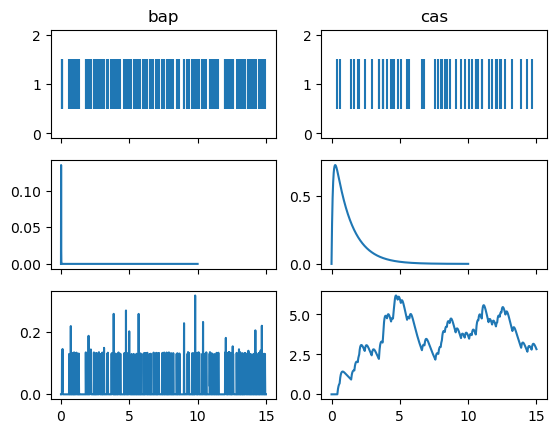

In [7]:
# Plot spikes, kernel, convolved Ca for each subprocess

fig, axs = plt.subplots(3,nprocs,sharex=True)
for i,name in enumerate(filter_names):
    filt = fpp.filter_instances[name]
    
    # Spikes
    axs[0,i].eventplot(simulated_spikes[i])
    axs[0,i].set_title(name)

    # Kernel
    kernel_ta = filt.kernel_time_axis
    kernel = filt.kernel
    axs[1,i].plot(kernel_ta,kernel)

    # Convolved Ca
    axs[2,i].plot(ta,simulated_Ca_byProcess[i])

Text(0.5, 0, 'Freq (Hz)')

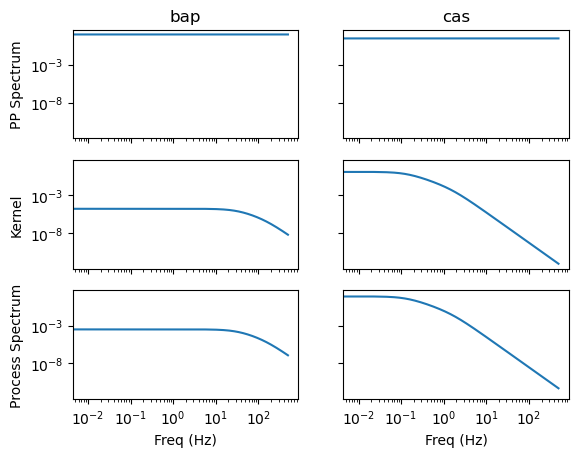

In [8]:
# Plot spectra for each subprocess

ppfd = model.pp.frequency_domain
ppfreqs = ppfd.frequencies
ppPSD = ppfd.PSD


fig, axs = plt.subplots(3,nprocs,sharex=True,sharey=True)

for i,name in enumerate(filter_names):
    filt = fpp.filter_instances[name]

    axs[0,i].loglog(ppfreqs,ppPSD[i])
    axs[0,i].set_title(name)
    
    axs[1,i].loglog(filt.frequencies,filt.kernel_spectrum)

    axs[2,i].loglog(fpp.frequencies,fpp.final_spectrum_per_process[i,:])

axs[0,0].set_ylabel('PP Spectrum')
axs[1,0].set_ylabel('Kernel')
axs[2,0].set_ylabel('Process Spectrum')
axs[2,0].set_xlabel('Freq (Hz)')
axs[2,1].set_xlabel('Freq (Hz)')

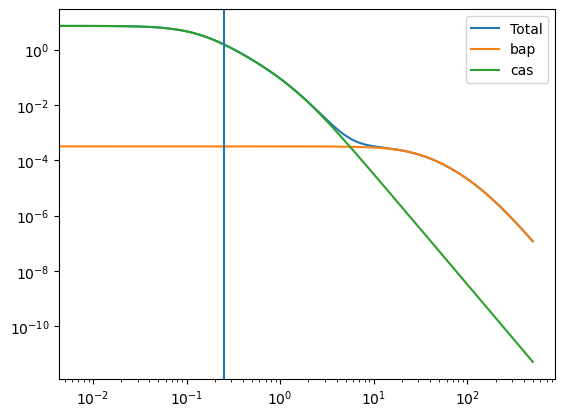

In [9]:
# Plot final spectrum breakdown

plt.loglog(fpp.frequencies,fpp.final_spectrum,label='Total')
for i,name in enumerate(filter_names):
    plt.loglog(fpp.frequencies,fpp.final_spectrum_per_process[i,:],label=name)
plt.legend()